# Create Dendrogram based on Proteome Similarity from given Cluster(s)


In [121]:
import pandas as pd
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [122]:
CLUSTER_IDS = [4]
MIN_CLUSTER_SIZE = 2

In [123]:
# Grab entries in cluster(s) from plot
df = pd.read_csv("../data/phage_PCA_coords_annot.tsv", sep="\t")
df = df[df["cluster"].isin(CLUSTER_IDS)].reset_index(drop=True)
print("Families in selecter cluster(s):\n", df["Family"].value_counts())

# Store all Accessions in the selected cluster(s)
# cluster_list = str(n).replace(" ", "")
# with open(f"../data/cluster_{cluster_list}_accessions.txt", "w") as fh:
#     fh.write("\n".join(df["Accession"].tolist()))

Families in selecter cluster(s):
 Family
Microviridae      66
Inoviridae        21
Schitoviridae      1
Sarkviridae        1
Casjensviridae     1
Name: count, dtype: int64


In [124]:
# Grab alignments of cluster members from foldseek all vs all alignment
df_fs = pd.read_csv(
    "../data/foldseek_allvsall.tsv",
    sep="\t",
    names=["query", "target", "evalue", "bitscore", "tmscore"],
)

In [125]:
accs = tuple(df["Accession"].to_list())

df_cluster = df_fs[
    df_fs["query"].str.startswith(accs) & df_fs["target"].str.startswith(accs)
]

In [126]:
# Keep meaningful structural alignments, TM score > 0.5
df_cluster = df_cluster[df_cluster["tmscore"] >= 0.5].reset_index(drop=True)
df_cluster

,query,target,evalue,bitscore,tmscore
0,KX266462.1_prot_ANS08112.1_7,KX266462.1_prot_ANS08112.1_7,7.143000e-16,600,1.0110
1,NC_074762.1_prot_YP_010774583.1_9,NC_074762.1_prot_YP_010774583.1_9,9.988000e-32,1721,1.0050
2,HM775310.1_prot_ADM16625.1_8,HM775310.1_prot_ADM16625.1_8,1.667000e-05,232,1.0270
3,HM775310.1_prot_ADM16625.1_8,KX266401.1_prot_ANS07442.1_8,1.645000e+00,35,0.5048
4,HM775310.1_prot_ADM16625.1_8,KX266442.1_prot_ANS07893.1_8,2.518000e+00,33,0.5128
...,...,...,...,...,...
7791,KX266328.1_prot_ANS06635.1_4,KX266399.1_prot_ANS07416.1_4,2.643000e-06,144,0.5607
7792,KX266328.1_prot_ANS06635.1_4,KX266514.1_prot_ANS08681.1_4,2.056000e-06,143,0.5408
7793,KX266328.1_prot_ANS06635.1_4,KX266401.1_prot_ANS07438.1_4,5.159000e-06,141,0.6020
7794,KX266328.1_prot_ANS06635.1_4,KX266416.1_prot_ANS07603.1_4,6.631000e-06,140,0.5986


In [ ]:
# Build protein-protein graph
all_proteins = pd.Index(pd.concat([df_cluster["query"], df_cluster["target"]]).unique())

G = nx.Graph()
G.add_nodes_from(all_proteins)

# Add edges weighted by TM score
for row in df_cluster.itertuples(index=False):
    q, t, e, b, tm = row
    # If edge exists, use max tm score
    if G.has_edge(q, t):
        if tm > G[q][t]["weight"]:
            G[q][t]["weight"] = tm
    else:
        G.add_edge(q, t, weight=tm)

# Optionally, save graph
# pos = nx.spring_layout(G, k=0.3, iterations=500, weight="weight")
# nx.write_graphml(G, "../data/protein_network.graphml")

print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

Graph nodes: 951, edges: 4805


In [128]:
# Detect communities / protein clusters
comms = nx.community.louvain_communities(G, weight="weight")

# Drop clusters smaller than minimum cluster size
comms = [n for n in comms if len(n) >= MIN_CLUSTER_SIZE]

In [129]:
# Build Accession x cluster_id matrix

# Cluster -> phage accession mapping
cluster_to_accessions = []
for i, cluster in enumerate(comms):
    phage_ids = set()
    for id in cluster:
        acc = id.split("_prot")[0]
        acc = acc.split(".")[0]  # Remove accession version
        phage_ids.add(acc)
    cluster_to_accessions.append((f"cluster_{i}", phage_ids))

all_accessions = list(set.union(*[phages for _, phages in cluster_to_accessions]))

assert len(all_accessions) == len(accs)  # Sanity check

# Dataframe with binary presence/absence for each cluster
# Init df with 0
presence_df = pd.DataFrame(
    0, index=all_accessions, columns=[c for c, _ in cluster_to_accessions]
)

# Fill df
for cluster_name, phages in cluster_to_accessions:
    presence_df.loc[list(phages), cluster_name] = 1

presence_df

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47
KX266576,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
MN890137,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
KX266563,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
EF489910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
JF719734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP017906,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
KX266328,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
MT901799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
PP631983,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [130]:
# Compute Jaccard similarity between proteomes
dist_vec = pdist(presence_df, metric="jaccard")
dist_mat = squareform(dist_vec)

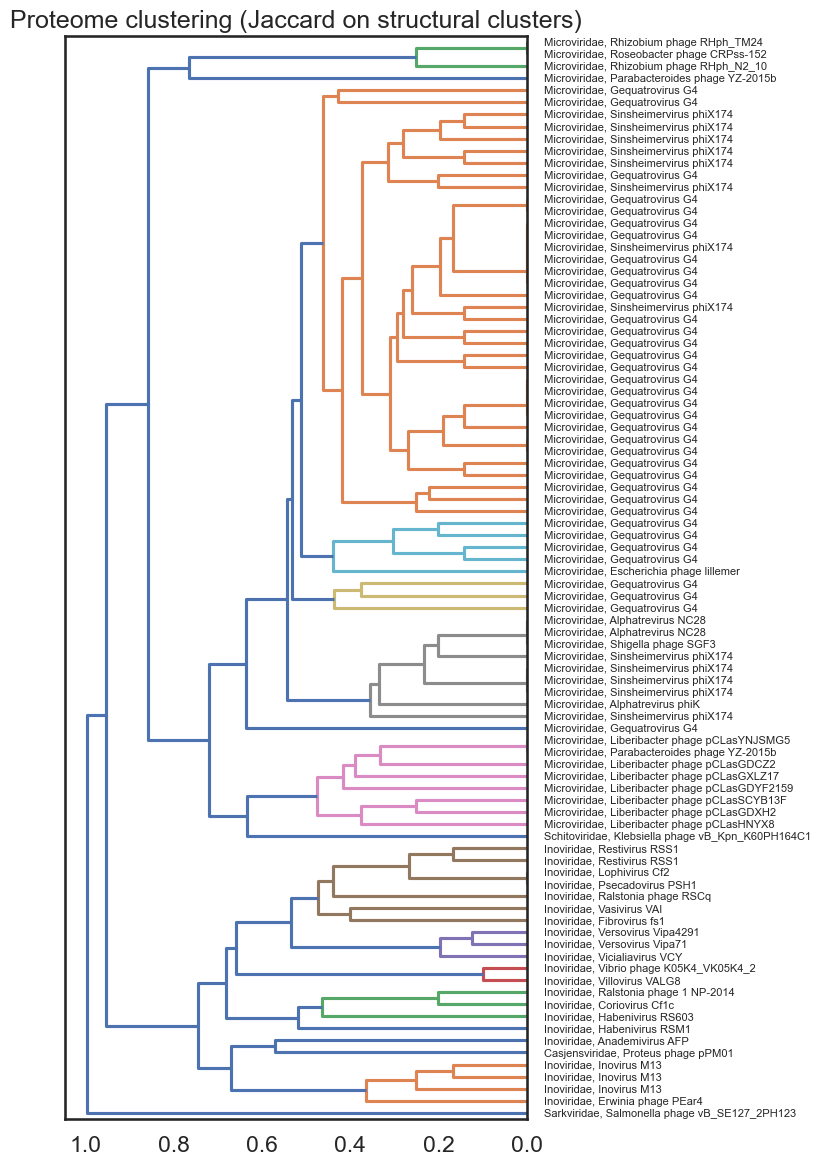

In [131]:
# Dendrogram
plt.figure(figsize=(8, 12))

# Ger species labels
df_meta = df.set_index("Accession")

labels = [
    f"{df_meta.loc[acc, 'Family']}, {df_meta.loc[acc, 'Species']}"
    for acc in presence_df.index
]

Z = linkage(dist_vec, method="average")  # UPGMA-like
dn = dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0,
    leaf_font_size=8,
    color_threshold=0.5,
    orientation="left",
)

plt.title("Proteome clustering (Jaccard on structural clusters)")
plt.tight_layout()
plt.show()